# <center> **Project 3. Kaggle competition. Regression Task**

**Descriprion**  
Imagine that you are a data scientist at Booking. One of the problems of the company is dishonest hotels that wind up their rating. One way to find such hotels is to build a model that predicts the rating of the hotel. If the predictions of the model are very different from the actual result, then the hotel may be playing unfairly and should be checked.

You are tasked with creating such a model.

**Target metric**  
The results are evaluated by the MAPE.

**About data**  
- hotel_address - hotel address
- review_date - the date the reviewer posted the corresponding review
- average_score - the hotel's average score, calculated based on the last comment for the last year
- hotel_name - hotel name
- reviewer_nationality - reviewer's nationality
- negative_review - negative review that the reviewer gave to the hotel.
- review_total_negative_word_counts - total number of words in negative review
- positive_review - positive review that the reviewer has given to the hotel
- review_total_positive_word_counts - total number of words in a positive review
- total_number_of_reviews_reviewer_has_given - Number of reviews that reviewers have given in the past
- total_number_of_reviews - total number of valid hotel reviews
- tags - tags that the reviewer gave to the hotel.
- days_since_review - duration between review date and cleanup date
- additional_number_of_scoring - There are also some guests who simply rated the service instead of leaving a review. This number indicates how many valid grades there are without validation.
- lat - latitude of the hotel
- lng - hotel longitude
- **reviewer_score** - is a target varuable - the rating given by the reviewer to the hotel based on their experience

**View File**  
For each hotel id in the test dataset, you must predict the hotel rating for the reviewer_score variable.

**Competition Files**  
- hotels_train.csv - training dataset
- hotels_test.csv - data set for quality assessment
- submission.csv - submission file in the required format

In [107]:
# main
import numpy as np
import pandas as pd

# machine learning
from sklearn import ensemble
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import optuna

from scipy import stats
from scipy.stats import shapiro
from geopy.distance import geodesic

# metrics and encoders
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
import category_encoders as ce

# visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns 

# for sentiment analysis
import string
import spacy
from afinn import Afinn
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
from textblob import TextBlob, Blobber
from textblob.sentiments import NaiveBayesAnalyzer

pd.set_option('display.max_columns', None)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\volod\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## <center> **Part I. Loading and exploring**

In [108]:
# load data
df_test = pd.read_csv('hotels_test.csv')
df_train = pd.read_csv('hotels_train.csv')
submission = pd.read_csv('submission.csv')

In [109]:
# mark the train and the test sample
df_train['sample'] = 1
df_test['sample'] = 0

# we ought to predict this value, what's why equate the value to 0 for now
df_test['reviewer_score'] = 0

# concat train and test to common data set
data = df_test.append(df_train, sort=False).reset_index(drop=True)

C:\Users\volod\AppData\Local\Temp\ipykernel_10676\1482299945.py:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [110]:
# display data
data.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


In [111]:
# check for gaps and dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

### According to the conditions of the problem, we cannot delete lines.

## <center> **Part II. Feature engineering**

### Hotel address

In [112]:
# check some duplitaces between address and name
name_address = data[['hotel_address', 'hotel_name']].groupby(by='hotel_name').nunique()

# create a list with hotel addresses
list_address = name_address[name_address['hotel_address'] != 1].index.to_list()
mask = data['hotel_name'].isin(list_address)

# same name and different addresses
same_address = data[mask][['hotel_address', 'hotel_name']].value_counts()
print('Same hotels with different addresses: \n', same_address)

Same hotels with different addresses: 
 hotel_address                                               hotel_name  
Bergara 2 4 Eixample 08002 Barcelona Spain                  Hotel Regina    590
Rooseveltplatz 15 09 Alsergrund 1090 Vienna Austria         Hotel Regina    284
Via Cesare Correnti 13 Milan City Center 20123 Milan Italy  Hotel Regina     60
dtype: int64


In [113]:
# add name for same address
data['hotel_name'] = data.apply(lambda row: 
    (row['hotel_name'] + ' ' + row['hotel_address'].split()[-2])
    if (row['hotel_name'] in list_address)
    else row['hotel_name'], axis=1)

# display results for combaining
mask = data['hotel_name'].str.contains(list_address[0])
data[mask]['hotel_name'].value_counts()

Hotel Regina Barcelona    590
Hotel Regina Vienna       284
Hotel Regina Milan         60
Name: hotel_name, dtype: int64

In [114]:
# create new feature - city of a hotel
data['hotel_city'] = data['hotel_address'].apply(lambda x: 'London' if x.split(' ')[-1] == 'Kingdom' else x.split(' ')[-2])

# create new feature - country of a hotel
data['hotel_country'] = data['hotel_address'].apply(lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1])

### Additional number of scoring

In [115]:
# displaying and thinking
data['additional_number_of_scoring'].value_counts()

2682    4789
2288    4256
2623    4169
1831    3578
1936    3212
        ... 
7         56
5         39
17        24
1         13
4         12
Name: additional_number_of_scoring, Length: 480, dtype: int64

Don't know what to do with this feature.

### Review date

In [116]:
# change to comfortable format - datetime
data['review_date'] = pd.to_datetime(data['review_date'])

In [117]:
# create a new feature - year of review
data['year_review'] = data['review_date'].dt.year

In [118]:
# create a new feature - season of review
data['season_review'] = data['review_date'].dt.month

def get_season(month):
    """function for definition of season for date review"""
    
    if month in list(range(3,6)):
        return 'spring'
    
    if month in list(range(6,9)):
        return 'summer'
    
    if month in list(range(9,12)):
        return 'autumn'
    
    else:
        return 'winter'


# transform this feature using this feature
data['season_review'] = data['season_review'].apply(get_season)

In [119]:
# encoding this feature
data = pd.get_dummies(data, columns=['season_review'])

In [120]:
# create new feature - day of month
data['day'] = data['review_date'].dt.day

In [121]:
# finally get rid of review_date
data = data.drop(['review_date'], axis=1)

### Hotel name

In [122]:
# group data by hotel name and average rating
hotels_names = data.groupby('hotel_name')['average_score'].agg(['mean', 'count'])

# select the best hotels
mask = (hotels_names['mean'] >= 9.0) & (hotels_names['count'] >= 100)
hotels_top = hotels_names[mask]

# sort best hotels 
hotels_top = hotels_top.sort_values(by=['mean', 'count'], ascending=False)
display(hotels_top)

,mean,count
hotel_name,,
Hotel Casa Camper,9.6,301
Hotel The Serras,9.6,213
Haymarket Hotel,9.6,121
H10 Casa Mimosa 4 Sup,9.6,116
41,9.6,103
...,...,...
H tel Duc De St Simon,9.0,115
Baglioni Hotel London The Leading Hotels of the World,9.0,114
H tel La Comtesse by Elegancia,9.0,111


In [123]:
# create new feature - categories of hotel names
data['hotel_cat'] = data['hotel_name'].apply(lambda x: x if x in hotels_top.index else 'other')

In [124]:
# encoding this feature
bin_encoder = ce.BinaryEncoder()
type_bin = bin_encoder.fit_transform(data['hotel_cat'])
data = pd.concat([data, type_bin], axis=1)

# get rid of this feature, the original one will use little bit later
data = data.drop('hotel_cat', axis=1)

### Nationality

In [125]:
# there are strange empties, i can't ignore it
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x.strip())

# leave the most common 29 and other is the rest
common_nation = data['reviewer_nationality'].value_counts().nlargest(29).index
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in common_nation else 'other' )

# create new feature - was a trip domestic?
data['domestic'] = data.apply(lambda x: 1 if x['reviewer_nationality'] == x['hotel_country'] else 0, axis=1)

# use dummies for
data = pd.get_dummies(data, columns=['reviewer_nationality'])

# remember about hotel_country, don't need it anymore
data = data.drop(['hotel_country'], axis=1)

### Negative review

In [126]:
# look at the most often values
data['negative_review'].value_counts().nlargest(15)

No Negative        127890
 Nothing            14295
 Nothing             4236
 nothing             2225
 N A                 1037
 None                 984
                      849
 N a                  509
 Breakfast            407
 Small room           373
 Location             368
 Everything           326
 All good             318
 Nothing really       316
 none                 302
Name: negative_review, dtype: int64

Negative review is an answer to the question that you did not like. Accordingly, the answer 'nothing' or 'everything was fine' is the absence of the negative part of the review.

In [127]:
# create a not negative list with key words
not_negative_list = ['No Negative', ' Nothing', ' Nothing ', ' nothing ', ' nothing', 
                     ' N A', ' N a', ' Nil', ' All good', ' Nothing really', ' none',
                     ' None', ' no complaints', ' No complaints', ' nothing really']

# create a new feacture - is any negative in this review
data['is_negative'] = data['negative_review'].apply(lambda x: 0 if x in not_negative_list else 1)

In [128]:
# change values for review with non-negative contents
data['negative_review'] = data['negative_review'].apply(lambda x: 'Positive' if x in not_negative_list else x)

Sentiment Intensity Analyzer

In [129]:
# do a sentiment analysis
sia_negative = SentimentIntensityAnalyzer()

# create a new feacture for each value obtained using this library
data['negative_review_sia'] = data['negative_review'].apply(lambda x: sia_negative.polarity_scores(x))
data['negative_neg'] = data['negative_review_sia'].apply(lambda x: x['neg'])
data['negative_neu'] = data['negative_review_sia'].apply(lambda x: x['neu'])
data['negative_pos'] = data['negative_review_sia'].apply(lambda x: x['pos'])

# the main value of this library
data['negative_compound'] = data['negative_review_sia'].apply(lambda x: x['compound'])

Afinn

In [130]:
# another method to do a sentiment analysis
neg_afinn = Afinn()

# create new feature obtained using this library
data['afinn_negative'] = data['negative_review'].apply(lambda x: neg_afinn.score(x))

Text Blob

In [131]:
def get_polarity(text):
    """func to get text polarity"""
    
    blob = TextBlob(text)
    
    return blob.sentiment_assessments.polarity


# creare new feature - the polarity value for every review
data['negative_polarity'] = data['negative_review'].apply(get_polarity)

In [132]:
# another method of this library
text_blob = Blobber(analyzer=NaiveBayesAnalyzer())

def get_blobber_sentiment(text):
    """func for getting the coefficients of negative and positive coloring"""
    
    blobber_sentiment = text_blob(text).sentiment
    
    return blobber_sentiment[1]


# create new feacture
data['negative_review_pos'] = data['negative_review'].apply(get_blobber_sentiment)

In [133]:
# create new feature depending on the class of review
data['negative_review_class'] = data['negative_review_pos'].apply(lambda x: 1 if x > 0.5 else 0)

In [134]:
# get rid of the original feature
data = data.drop(['negative_review'], axis=1)

### Review total negative word counts

In [135]:
# splitting and making handmade coding
data['number_of_negative_words'] = pd.cut(data['review_total_negative_word_counts'], [-1, 0, 5, 10, 20, 50, 100, 10000], labels=['0', '1', '2', '3', '4', '5', '6'])

# cast to explicit int type
data['number_of_negative_words'] = data['number_of_negative_words'].astype(int)

### Total number of reviews

In [136]:
# splitting and making handmade coding
data['number_of_reviews_cat'] = pd.cut(data['total_number_of_reviews'], [0, 100, 500, 1000, 3000, 5000, 10000, 1000000], labels=['0', '1', '2', '3', '4', '5', '6'])

# cast to explicit int type
data['number_of_reviews_cat'] = data['number_of_reviews_cat'].astype(int)

### Positive review

In [137]:
# check for wrong values
data['positive_review'].value_counts().nlargest(10)

No Positive        35946
 Location           9222
 Everything         2284
 location           1677
 Nothing            1243
 The location       1126
 Great location     1047
 Good location       927
 Location            915
 Everything          613
Name: positive_review, dtype: int64

Positive review is the answer to the question "what did you like"? Accordingly, the answer 'nothing' or 'None' is the absence of the positive part of the review.

In [138]:
# create a not positive list with key words
not_positive_list = ['No Positive', ' Nothing', ' nothing', ' nothing ', ' Nothing ', ' None', ' None ']

# create a new feacture - is any negative in this review
data['is_positive'] = data['positive_review'].apply(lambda x: 0 if x in not_positive_list else 1)

In [139]:
# change values for review with non-negative contents
data['positive_review'] = data['positive_review'].apply(lambda x: 'Negative' if x in not_positive_list else x)

Sentiment Intensity Analyzer

In [140]:
# do a sentiment analysis
sia_positive = SentimentIntensityAnalyzer()

# create a new feacture for each value obtained using this library
data['positive_review_sia'] = data['positive_review'].apply(lambda x: sia_positive.polarity_scores(x))
data['positive_neg'] = data['positive_review_sia'].apply(lambda x: x['neg'])
data['positive_neu'] = data['positive_review_sia'].apply(lambda x: x['neu'])
data['positive_pos'] = data['positive_review_sia'].apply(lambda x: x['pos'])

# the main value of this library
data['positive_compound'] = data['positive_review_sia'].apply(lambda x: x['compound'])

Afinn

In [141]:
# another method to do a sentiment analysis
pos_afinn = Afinn()

# create new feature obtained using this library
data['afinn_positive'] = data['positive_review'].apply(lambda x: pos_afinn.score(x))

Text Blob

In [142]:
# try to use another one library for sentiment analysis
def get_polarity(text):
    """func to get text polarity"""
    
    blob = TextBlob(text)
    
    return blob.sentiment_assessments.polarity


# creare new feature - the polarity value for every review
data['positive_polarity'] = data['positive_review'].apply(get_polarity)

In [143]:
# another method of this library
text_blob = Blobber(analyzer=NaiveBayesAnalyzer())

def get_blobber_sentiment(text):
    """func for getting the coefficients of negative and positive coloring"""
    
    blobber_sentiment = text_blob(text).sentiment
    
    return blobber_sentiment[1]


# create new feacture
data['positive_review_pos'] = data['positive_review'].apply(get_blobber_sentiment)

In [144]:
# create new feature depending on the class of review
data['positive_review_class'] = data['positive_review_pos'].apply(lambda x: 1 if x >= 0.5 else 0)

In [145]:
# get rid of the original feature
data = data.drop(['positive_review'], axis=1)

### Review total positive word counts

In [146]:
# create new feature - sum numbers of words in both reviews
data['review_total_word_counts'] = data['review_total_positive_word_counts'] + data['review_total_negative_word_counts']

# calculate the ratio of the number of words
data['review_positive_word_proportion'] = data.apply(
    lambda row: 0.5 if row['review_total_word_counts'] == 0 #/
    else row['review_total_positive_word_counts'] / row['review_total_word_counts'], axis=1)

# get rid of the sum number of words
# data = data.drop('review_total_word_counts', axis = 1)

In [147]:
# let's compare number of reviews in both groups
# but we have to normalize values firstly
mm_scaler = MinMaxScaler()

# normalize for positive
data['review_total_positive_word_counts_norm']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(data['review_total_positive_word_counts'])),
    columns=['review_total_positive_word_counts'])

# normalize for negative
data['review_total_negative_word_counts_norm']  = pd.DataFrame(
    mm_scaler.fit_transform(pd.DataFrame(data['review_total_negative_word_counts'])),
    columns=['review_total_negative_word_counts'])

# calculate the differrence between them
data['counts_diff_norm'] = data['review_total_positive_word_counts_norm'] - data['review_total_negative_word_counts_norm']

# also add one more feature - who is dominate
data['positive_words_more'] = data['counts_diff_norm'].apply(
    lambda x: 1 if x >= 0 else 0)

# get rid of the intermediate feactures
data = data.drop(['review_total_positive_word_counts_norm', 'review_total_negative_word_counts_norm'], axis=1)

In [148]:
# splitting and making handmade coding
data['number_of_positive_words'] = pd.cut(data['review_total_positive_word_counts'], [-1, 0, 5, 10, 20, 50, 100, 10000], labels=['0', '1', '2', '3', '4', '5', '6'])

# cast to explicit int type
data['number_of_positive_words'] = data['number_of_positive_words'].astype(int)

### Total number of reviews reviewer has given

In [149]:
# let's take a look and think about some transformation
data['total_number_of_reviews_reviewer_has_given']

0          1
1          7
2         15
3          9
4          2
          ..
515733    10
515734     1
515735    21
515736    28
515737     2
Name: total_number_of_reviews_reviewer_has_given, Length: 515738, dtype: int64

Very interesting but not clear.

### Tags

In [150]:
def get_tags(data):
    """func for changing an array to a list"""
    
    # create a list for tags
    tags = []
    
    # get rid of useless gaps and symbols
    for tag in list(data.replace('[', '').replace(']', '').replace("'", '').split(',')):
        tag = tag.strip()
        tags.append(tag)
        
    return tags


# use this func for our feature
data['tags'] = data['tags'].apply(get_tags)

In [151]:
# find the number of unique tags
tags_list = []
for tags in data['tags']:
    tags_list.extend(tags)

# display the number of unique tags
len(set(tags_list))

2428

In [152]:
# use counter for finding the most popular tags
from collections import Counter
tags_counter = Counter(tags_list)

# display the 20 most popular tags
tags_counter.most_common(20)

[('Leisure trip', 417778),
 ('Submitted from a mobile device', 307640),
 ('Couple', 252294),
 ('Stayed 1 night', 193645),
 ('Stayed 2 nights', 133937),
 ('Solo traveler', 108545),
 ('Stayed 3 nights', 95821),
 ('Business trip', 82939),
 ('Group', 65392),
 ('Family with young children', 61015),
 ('Stayed 4 nights', 47817),
 ('Double Room', 35207),
 ('Standard Double Room', 32248),
 ('Superior Double Room', 31393),
 ('Family with older children', 26349),
 ('Deluxe Double Room', 24823),
 ('Double or Twin Room', 22393),
 ('Stayed 5 nights', 20845),
 ('Standard Double or Twin Room', 17483),
 ('Classic Double Room', 16989)]

In [153]:
# a goal of trip is one of the most common tag, so let's make two new features
data['leisure_trip'] = data['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)
data['business_trip'] = data['tags'].apply(lambda x: 1 if 'Business trip' in x else 0)

In [154]:
# is the way of review submission important? - will see
data['from_mobile'] = data['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)

In [155]:
# create several features from staying duration
data['one_night'] = data['tags'].apply(lambda x: 1 if 'Stayed 1 night' in x else 0)
data['two_nights'] = data['tags'].apply(lambda x: 1 if 'Stayed 2 nights' in x else 0)
data['three_nights'] = data['tags'].apply(lambda x: 1 if 'Stayed 3 nights' in x else 0)

In [156]:
# create several features from numbers of guests
data['solo'] = data['tags'].apply(lambda x: 1 if 'Solo traveler' in x else 0)
data['couple'] = data['tags'].apply(lambda x: 1 if 'Couple' in x else 0)
data['group'] = data['tags'].apply(lambda x: 1 if 'Group' in x else 0)

# and for people with children
data['with_children'] = data['tags'].apply(lambda x: 1 if ('Family with young children' in x) 
                                                        or ('Family with older children' in x) else 0)

In [157]:
# finally drop this feature
data = data.drop(['tags'], axis=1)

### Days since review

In [158]:
def get_days_since_review(days):
    """func for transforming value to int"""
    
    days = days.split(' ')[0]
    
    return int(days)

# transform the feature to int
data['days_since_review'] = data['days_since_review'].apply(get_days_since_review)

### LAT and LNG

In [159]:
# remember about the gaps in these columns
# find all hotels with empty coordinates
unique_hotels = data[['hotel_address', 'lat', 'lng']].drop_duplicates()
unique_hotels[unique_hotels['lat'].isnull() == True]

,hotel_address,lat,lng
35,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,NaN,NaN
476,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,NaN,NaN
526,23 Rue Damr mont 18th arr 75018 Paris France,NaN,NaN
569,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,NaN,NaN
609,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,NaN,NaN
774,Josefst dter Stra e 22 08 Josefstadt 1080 Vien...,NaN,NaN
1285,Bail n 4 6 Eixample 08010 Barcelona Spain,NaN,NaN
2389,Landstra er G rtel 5 03 Landstra e 1030 Vienna...,NaN,NaN
2802,4 rue de la P pini re 8th arr 75008 Paris France,NaN,NaN
3495,20 Rue De La Ga t 14th arr 75014 Paris France,NaN,NaN


In [160]:
# fill in the gaps
# thanks for Google Maps for that, i don't know any alternatives
hotels_coordinates = pd.DataFrame({
    'hotel_address':[
    'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
    'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
    'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
    '4 rue de la P pini re 8th arr 75008 Paris France',
    'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
    'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
    'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
    'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
    'Bail n 4 6 Eixample 08010 Barcelona Spain',
    'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
    'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
    'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',
    '23 Rue Damr mont 18th arr 75018 Paris France',
    'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
    '20 Rue De La Ga t 14th arr 75014 Paris France',
    'Pau Clar s 122 Eixample 08009 Barcelona Spain',
    'Sep lveda 180 Eixample 08011 Barcelona Spain'], 
    
    'lat':[
    48.209910,
    48.21360,
    48.22036,
    48.87532,
    48.18888,
    48.21700,
    48.21975,
    48.24614,
    41.39181,
    48.22163,
    48.20971,
    48.20973,
    48.88910,
    48.18814,
    48.84012,
    41.39272,
    41.38340], 
    
    'lng':[  
    16.353425,
    16.37988,
    16.35580,
    2.32338,
    16.38377,
    16.35989,
    16.28565,
    16.34153,
    2.17784,
    16.36641,
    16.35145,
    16.35148,
    2.33310,
    16.42049,
    2.32357,
    2.16739,
    2.16294]
})

In [161]:
# connect these table 
unique_hotels = (unique_hotels.merge(hotels_coordinates,
    on='hotel_address',
    how='left',
    suffixes=('','\x00')).sort_index(axis=1).bfill(axis=1)[unique_hotels.columns])

# add a city of hotel feature to this table
unique_hotels['hotel_city'] = data['hotel_address'].apply(lambda x: 'London' if x.split(' ')[-1] == 'Kingdom' else x.split(' ')[-2])

In [162]:
# let's find city center by GoogleMaps
city_center = pd.DataFrame({
    'hotel_city':[
        'London',
        'Barcelona',
        'Paris',
        'Amsterdam',
        'Vienna',
        'Milan'],
    'city_lat':[
        51.507322,
        41.382894,
        48.853495,
        52.372760,
        48.208354,
        45.464194],
    'city_lng':[
        -0.127647,
        2.177432,
        2.348391,
        4.893604,
        16.372504,
        9.189635]
})

# display this table
city_center

,hotel_city,city_lat,city_lng
0,London,51.507322,-0.127647
1,Barcelona,41.382894,2.177432
2,Paris,48.853495,2.348391
3,Amsterdam,52.372760,4.893604
4,Vienna,48.208354,16.372504
5,Milan,45.464194,9.189635


In [163]:
# emmerge table with city centres
unique_hotels = unique_hotels.merge(city_center, how='left', on='hotel_city', sort=False)

# create new feature - it contains hotel and city center coordinate
unique_hotels['coordinates'] = list(zip(
    unique_hotels['lat'], 
    unique_hotels['lng'], 
    unique_hotels['city_lat'], 
    unique_hotels['city_lng']
))

# display this table
unique_hotels.head()

,hotel_address,lat,lng,hotel_city,city_lat,city_lng,coordinates
0,Via Senigallia 6 20161 Milan Italy,45.533137,9.171102,Milan,45.464194,9.189635,"(45.5331372, 9.1711019, 45.464194, 9.189635)"
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,52.385649,4.834443,Amsterdam,52.372760,4.893604,"(52.3856494, 4.834443, 52.37276, 4.893604)"
2,Mallorca 251 Eixample 08008 Barcelona Spain,41.393192,2.16152,Barcelona,41.382894,2.177432,"(41.3931918, 2.16152, 41.382894, 2.177432)"
3,Piazza Della Repubblica 17 Central Station 201...,45.479888,9.196298,Milan,45.464194,9.189635,"(45.479888, 9.1962982, 45.464194, 9.189635)"
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,52.370545,4.888644,Amsterdam,52.372760,4.893604,"(52.3705447, 4.8886439, 52.37276, 4.893604)"


In [164]:
def get_distance_to_center(coordinates):
    """func for calculating distance between center and a hotel"""
    
    coord_1 = coordinates[:2]
    coord_2 = coordinates[-2:]
    
    return geodesic(coord_1, coord_2).km


# create one more feature
unique_hotels['distance_to_center'] = unique_hotels['coordinates'].apply(get_distance_to_center)

In [165]:
# discard useless features
unique_hotels = unique_hotels.drop(['lat','lng','city_lat','city_lng', 'hotel_city','coordinates'], axis=1)

# dinally update our data by the new feature
data = data.merge(
    right=unique_hotels,
    how='left',
    on='hotel_address'
)

In [166]:
# get rid of the original feature
data = data.drop(['lat', 'lng'], axis=1)

## <center> **Part III. Feature Selection**

### Check for any non-numeric features

In [167]:
# display it
data.dtypes[data.dtypes == 'object']

hotel_address          object
hotel_name             object
hotel_city             object
negative_review_sia    object
positive_review_sia    object
dtype: object

In [168]:
# check manually
data.head(1)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,reviewer_score,hotel_city,year_review,season_review_autumn,season_review_spring,season_review_summer,season_review_winter,day,hotel_cat_0,hotel_cat_1,hotel_cat_2,hotel_cat_3,hotel_cat_4,hotel_cat_5,hotel_cat_6,hotel_cat_7,domestic,reviewer_nationality_Australia,reviewer_nationality_Belgium,reviewer_nationality_Canada,reviewer_nationality_China,reviewer_nationality_France,reviewer_nationality_Germany,reviewer_nationality_Greece,reviewer_nationality_Hong Kong,reviewer_nationality_India,reviewer_nationality_Ireland,reviewer_nationality_Israel,reviewer_nationality_Italy,reviewer_nationality_Kuwait,reviewer_nationality_Netherlands,reviewer_nationality_New Zealand,reviewer_nationality_Poland,reviewer_nationality_Qatar,reviewer_nationality_Romania,reviewer_nationality_Russia,reviewer_nationality_Saudi Arabia,reviewer_nationality_Singapore,reviewer_nationality_South Africa,reviewer_nationality_Spain,reviewer_nationality_Sweden,reviewer_nationality_Switzerland,reviewer_nationality_Turkey,reviewer_nationality_United Arab Emirates,reviewer_nationality_United Kingdom,reviewer_nationality_United States of America,reviewer_nationality_other,is_negative,negative_review_sia,negative_neg,negative_neu,negative_pos,negative_compound,afinn_negative,negative_polarity,negative_review_pos,negative_review_class,number_of_negative_words,number_of_reviews_cat,is_positive,positive_review_sia,positive_neg,positive_neu,positive_pos,positive_compound,afinn_positive,positive_polarity,positive_review_pos,positive_review_class,review_total_word_counts,review_positive_word_proportion,counts_diff_norm,positive_words_more,number_of_positive_words,leisure_trip,business_trip,from_mobile,one_night,two_nights,three_nights,solo,couple,group,with_children,distance_to_center
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,52,16670,62,1,13,0,0.0,Milan,2017,0,0,1,0,21,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,"{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...",0.129,0.747,0.125,-0.0554,5.0,-0.05,0.956721,1,5,6,1,"{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",0.0,0.671,0.329,0.9615,20.0,0.461364,0.995351,1,114,0.54386,0.029511,1,5,1,0,0,0,1,0,0,1,0,0,7.79817


In [169]:
# get rid of non-numerical features
data = data.drop(['hotel_address', 'hotel_name', 'positive_review_sia', 'negative_review_sia'], axis=1)

# use dummies for encoding
data = pd.get_dummies(data, columns=['hotel_city'])

### Create new features

In [170]:
# calculate the difference between pompounds
data['diff_compound'] = data['positive_compound'] + data['negative_compound']

# multiply this feature on the word proportion
data['diff_compound_prop'] = data['diff_compound'] * data['review_positive_word_proportion']

# and create one more unclear
data['negative_compound_words'] = data['negative_compound'] * data['number_of_negative_words']

# calculate which part is dominating
data['positive_or_negative'] = data['is_positive'] - data['is_negative']

### Correlation

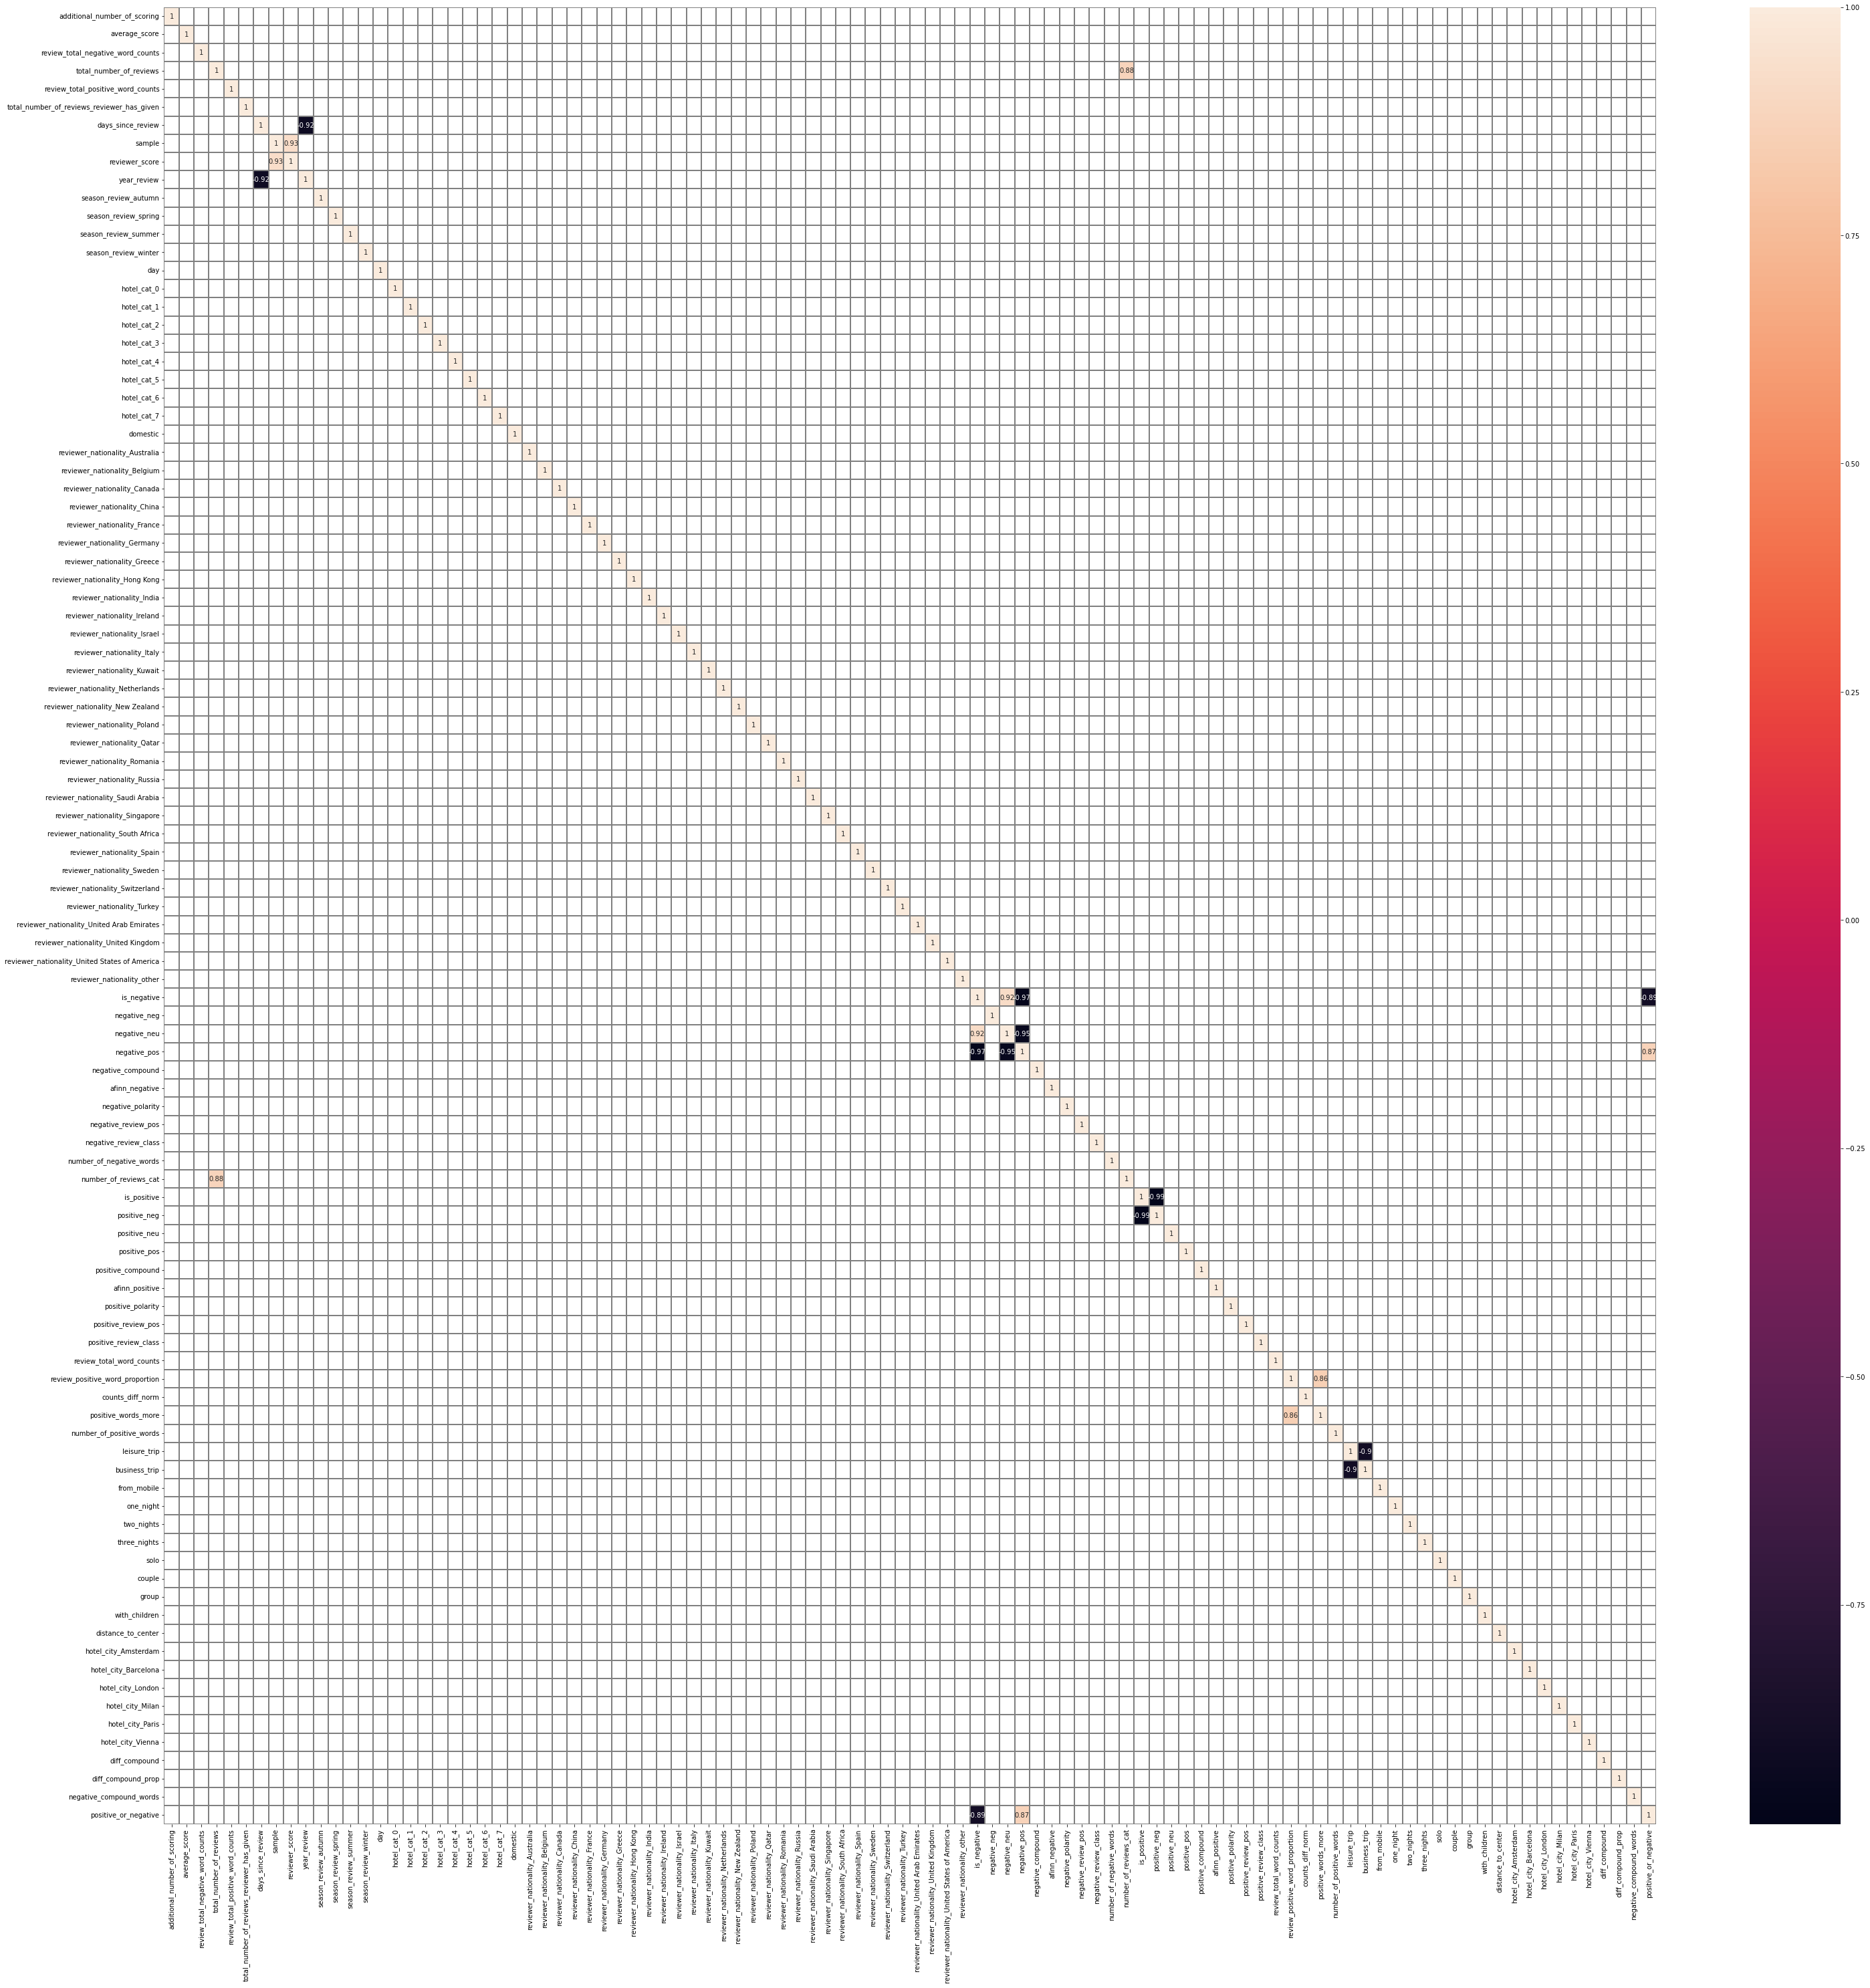

In [171]:
# check correlation
corr = data.corr()

# picturaze
fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(round(corr[corr.abs() > 0.85], 2), annot=True, linewidths=0.1, linecolor='gray', ax=ax);

Yeah-yeah. I know you can't see anything, but i've used an expanded graph.

### Correlation with the target feature

In [172]:
# group data
corr = data[data['sample'] == 1].corr()
corr_df = round(corr['reviewer_score'].sort_values(ascending=True), 3)

# picturaze
target_corr = px.bar(
    data_frame=corr_df,
    orientation='h',
    color='value',
    height=2000,
    width=800,
    title='Correlation with target vaue'
)
target_corr.update_layout(title=dict(x=.5, xanchor='center'),
                           title_font_size=20)

# display
target_corr.show() #'png'

In [173]:
# let's get rid of some features
# 'sample' will be dropped soon
data = data.drop(['days_since_review', 'total_number_of_reviews', 'positive_neg', 'negative_pos', 'negative_neu'], axis=1)

## <center> **Part IV. Machine learing**

### Gradient Boosting Regressor

In [186]:
# separate set to train and test
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

# define x and y
y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

# splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [176]:
# build a model
model = GradientBoostingRegressor(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 40
)

# training the model
model.fit(X_train, y_train)

# predict and calculate results for the training sample
y_train_pred = model.predict(X_train)
print('Train MAPE: {:.4f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))

# predict and calculate results for the testing sample
y_test_pred = model.predict(X_test)
print('Test MAPE: {:.4f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)))

Train MAPE: 0.1169
Test MAPE: 0.1185


In [177]:
# get rid of the id feature
test_data = test_data.drop(['reviewer_score'], axis=1)

# predict for the whole test sample
predict_submission = model.predict(test_data)
submission['reviewer_score'] = predict_submission

# save and diaplsy results
submission.to_csv('submission.csv', index=False)
submission.head(10)

,reviewer_score,id
0,8.748132,488440
1,7.770285,274649
2,8.284639,374688
3,9.667836,404352
4,9.457275,451596
5,9.178486,302161
6,8.042774,317079
7,8.228621,13963
8,8.362936,159785
9,7.583365,195089


_____________

### Gradient Boosting Regressor with scaling

In [204]:
# separate set to train and test
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

# define x and y
y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

# splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [195]:
# call a scaler
robust_scaler = preprocessing.RobustScaler()

# fit on the training
robust_scaler.fit(X_train, y_train)

# transform both samples
X_train_scaled = robust_scaler.transform(X_train)
X_test_scaled = robust_scaler.transform(X_test)

In [196]:
# build a model
gradient_boost = GradientBoostingRegressor(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 40
)

# training the model
gradient_boost.fit(X_train_scaled, y_train)

# predict and calculate results for the training sample
y_train_pred = gradient_boost.predict(X_train_scaled)
print('Train MAPE: {:.4f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))

# predict and calculate results for the testing sample
y_test_pred = gradient_boost.predict(X_test_scaled)
print('Test MAPE: {:.4f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)))

Train MAPE: 0.1169
Test MAPE: 0.1185


In [200]:
# get rid of the id feature
test_data = test_data.drop(['reviewer_score'], axis=1)

# scaling test data
test_data = robust_scaler.transform(test_data)

# predict for the whole test sample
predict_submission = gradient_boost.predict(test_data)
submission['reviewer_score'] = predict_submission

# save and diaplsy results
submission.to_csv('submission_gbr.csv', index=False)
submission.head(10)

,reviewer_score,id
0,8.751766,488440
1,7.752895,274649
2,8.295964,374688
3,9.660345,404352
4,9.457263,451596
5,9.173939,302161
6,8.049397,317079
7,8.224026,13963
8,8.388748,159785
9,7.580834,195089


_____________

### Random forest regressor

In [70]:
# model building
model = RandomForestRegressor(
    n_estimators=100, 
    verbose=1, 
    n_jobs=-1, 
    random_state=40)

# train the model
model.fit(X_train, y_train)

# predict and caltulate metric for the training
y_train_pred = model.predict(X_train)
print('Train MAPE: {:.4f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred) * 100))

# predict and caltulate metric for the testing
y_test_pred = model.predict(X_test)
print('Test MAPE: {:.4f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred) * 100))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Train MAPE: 4.4819


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s


Test MAPE: 12.0611


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


### Updated random forest regressor

In [72]:
# model building
random_forest = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_leaf=5, 
    verbose=1, 
    n_jobs=-1, 
    random_state=40
)

# training this model
random_forest.fit(X_train, y_train)

# predict and caltulate metric for the training
y_train_pred = random_forest.predict(X_train)
print('Train: {:.4f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))

# predict and caltulate metric for the testing
y_test_pred = random_forest.predict(X_test)
print('Test: {:.4f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 16.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    6.8s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    7.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Train: 0.1013


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.7s


Test: 0.1202


[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    2.0s finished


### Random Forest with the scaled data

In [75]:
# build a model
random_forest = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_leaf=5, 
    verbose=1, 
    n_jobs=-1, 
    random_state=40
)

# training this model
random_forest.fit(X_train_scaled, y_train)

# predict and caltulate metric for the training
y_train_pred = random_forest.predict(X_train_scaled)
print('Train: {:.4f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))

# predict and caltulate metric for the testing
y_test_pred = random_forest.predict(X_test_scaled)
print('Test: {:.4f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 16.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    6.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    7.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


Train: 0.1013


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.5s


Test: 0.1202


[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.7s finished


### Linear Regression

In [76]:
# build a moedl
log_reg = linear_model.LinearRegression()

# training this model
log_reg.fit(X_train_scaled, y_train)

# predict and caltulate metric for the training
y_train_pred = log_reg.predict(X_train_scaled)
print('Train MAPE: {:.4f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred) * 100))

# predict and caltulate metric for the testing
y_test_pred = log_reg.predict(X_test_scaled)
print('Test MAPE: {:.4f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred) * 100))

Test MAPE: 12.7178


### SGD

In [79]:
# build a model
sgd_lr = linear_model.SGDRegressor(random_state=40)

# train the model
sgd_lr.fit(X_train_scaled, y_train)

# predict and calculate results for the training sample
y_train_pred = sgd_lr.predict(X_train_scaled)
print('Train MAPE: {:.4f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))

# predict and calculate results for the testing sample
y_test_pred = sgd_lr.predict(X_test_scaled)
print('Test MAPE: {:.4f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)))

Train MAPE: 0.1272
Test MAPE: 0.1273


### STACKING

In [82]:
# all models
estimators = [
    ('rf', random_forest),
    ('lr', log_reg),
    ('gb', gradient_boost),
    ('sgd', sgd_lr)
]

# call a stack model
stack_forest = StackingRegressor(
    estimators=estimators,
    final_estimator=ensemble.RandomForestRegressor(n_estimators=100,
                                                    max_depth=7,
                                                    min_samples_leaf=3,
                                                    random_state=40)
)

# training the model
stack_forest.fit(X_train_scaled, y_train)

# predict and calculate results for the training sample
y_train_pred = stack_forest.predict(X_train_scaled)
print('Train MAPE: {:.4f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_pred)))

# predict and calculate results for the testing sample
y_test_pred = stack_forest.predict(X_test_scaled)
print('Test MAPE: {:.4f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_pred)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 18.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 15.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.7s finished
[

Train MAPE: 0.1153


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.9s finished


Test MAPE: 0.1180


In [205]:
# load again the original test sample
test_data = data.query('sample == 0').drop(['sample'], axis=1)

# get rid of the target value
test_data = test_data.drop(['reviewer_score'], axis=1)

# scaling the test sample
test_data = robust_scaler.transform(test_data)

# predict results
predict_submission = stack_forest.predict(test_data)
submission['reviewer_score'] = predict_submission

# save and display results
submission.to_csv('submission_sf.csv', index=False)
submission.head(10)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    4.0s finished


,reviewer_score,id
0,8.749923,488440
1,7.685632,274649
2,8.322552,374688
3,9.715697,404352
4,9.508409,451596
5,9.188668,302161
6,8.048213,317079
7,8.236865,13963
8,8.375993,159785
9,7.650313,195089


## <center> **Conclusion**
Work was carried out with each feature separately, a large number of new highly correlated features with the target was created. Several machine learning models have been built. Using the stacking regressor model, we managed to achieve the target metric (MAPE) less than 12%.   
At the end of December 2022, the result is in the top 10 in [this competition](https://www.kaggle.com/competitions/sf-booking/leaderboard).

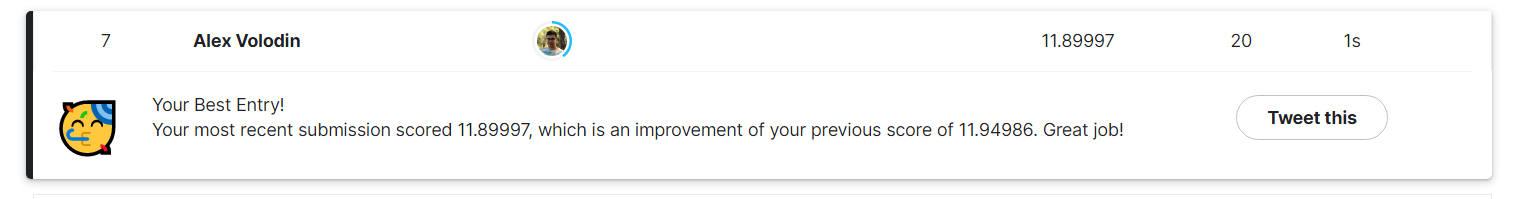